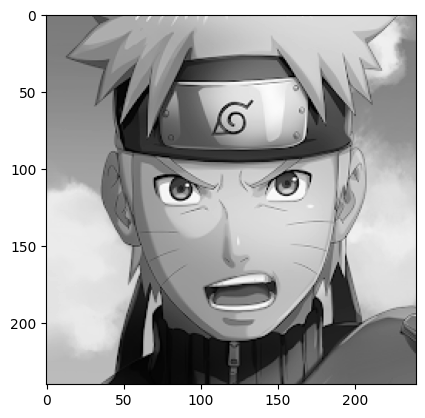

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import dct, idct

img = cv2.imread('imgs/naruto.webp', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap='gray')

In [ ]:
plt.hist(img)
plt.show()

In [ ]:
Y = np.zeros(img.shape)

U = img.shape[0]//8
V = img.shape[1]//8
for u in range(U):
    for v in range(V):
        img_blck = img[u*8: u*8 + 8, v*8: v*8 + 8] - 128
        Y[u*8: u*8 + 8, v*8: v*8 + 8] = dct(dct(img_blck, axis=0, norm='ortho'), axis=1, norm='ortho')

# plt.imshow(Y, cmap='gray')
plt.hist(Y)

In [ ]:
quantization = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99],
])

In [ ]:
Y_quant = np.zeros(img.shape)

for u in range(U):
    for v in range(V):
        Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] = Y[u*8 : u*8 + 8, v*8 : v*8 + 8] / quantization
        # Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] *= np.abs(Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8]) > 1

plt.hist(Y_quant)
plt.show()

In [ ]:
img_rec = np.zeros(img.shape)
for u in range(U):
    for v in range(V):
        img_rec[u*8 : u*8 + 8, v*8 : v*8 + 8] = idct(idct(Y_quant[u*8 : u*8 + 8, v*8 : v*8 + 8] * quantization, axis=0, norm='ortho'), axis=1, norm='ortho')


In [ ]:
# plt.imshow((img_rec + 128), cmap='gray')
plt.hist((img_rec + 128))

Em blocos

In [ ]:
Y_blck = np.zeros((64, 64))

for u in range(8):
    for v in range(8):
        Y_blck[u*8 : u*8 + 8, v*8 : v*8 + 8] = dct(dct(img[u*8 : u*8 + 8, v*8 : v*8 + 8], axis=0), axis=1)

In [ ]:
plt.imshow(Y_blck, cmap='gray')

In [ ]:
u = 1
v = 6
print(Y_blck[u*8: u*8 + 8, v*8: v*8+8])

